In [1]:
import os
import requests
import random
import math
import numpy as np
import matplotlib.pyplot as plt
from sklearn import linear_model, model_selection
from tqdm import tqdm
from scipy.special import kl_div
import gc
from sklearn.metrics.pairwise import cosine_similarity, euclidean_distances
import pandas as pd
from copy import deepcopy

import torch
import torch.nn.functional as F
from torch import nn
from torch.nn.utils import prune
from torch import optim
from torch.utils.data import DataLoader, Dataset, TensorDataset, Subset
from torch.optim.lr_scheduler import _LRScheduler

import torchvision
from torchvision import transforms
from torchvision.utils import make_grid
from torchvision.models import resnet18
from torchvision.models.feature_extraction import create_feature_extractor

DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
print("Running on device:", DEVICE.upper())

# manual random seed is used for dataset partitioning
# to ensure reproducible results across runs
SEED = 42
RNG = torch.Generator().manual_seed(SEED)
random.seed(SEED)
torch.manual_seed(SEED)

import sys
sys.path.append('../')
from utils import *

import pickle
import PIL
from tqdm import tqdm

Running on device: CUDA


In [2]:
import ssl

# Create an unverified SSL context
ssl._create_default_https_context = ssl._create_unverified_context

In [3]:
with open('./imbalanced_cifar/imbalanced_dataset.pkl', 'rb') as file:
    imbalanced_aug_dataset_id = pickle.load(file)

train_idx = np.load('./imbalanced_cifar/train_idx.npy')
retain_idx = np.load('./imbalanced_cifar/retain_idx.npy')
forget_idx = np.load('./imbalanced_cifar/forget_idx.npy')
val_idx = np.load('./imbalanced_cifar/val_idx.npy')
test_idx = np.load('./imbalanced_cifar/test_idx.npy')

train_set = torch.utils.data.Subset(imbalanced_aug_dataset_id, train_idx)
forget_set = torch.utils.data.Subset(imbalanced_aug_dataset_id, forget_idx)
retain_set = torch.utils.data.Subset(imbalanced_aug_dataset_id, retain_idx)
val_set = torch.utils.data.Subset(imbalanced_aug_dataset_id, val_idx)
test_set = torch.utils.data.Subset(imbalanced_aug_dataset_id, test_idx)

In [4]:
class CustomDataset(Dataset):
    def __init__(self, data_list, transform=None):
        self.data_list = data_list
        self.transform = transform

    def __len__(self):
        return len(self.data_list)

    def __getitem__(self, idx):
        x, y, z = self.data_list[idx]

        # If x is a PIL.Image, convert it to a tensor
        if isinstance(x, PIL.Image.Image):
            x = transforms.ToTensor()(x)

        # Apply additional transformations (like normalization)s
        if self.transform:
            x = self.transform(x)

        return (x, y)  # Explicitly return as tuple

# download and pre-process CIFAR10
train_normalize = transforms.Compose(
    [
        transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
    ]
)

test_normalize = transforms.Compose(
    [
        transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
    ]
)

train_dataset = CustomDataset(train_set, transform=train_normalize)
forget_dataset = CustomDataset(forget_set, transform=train_normalize)
retain_dataset = CustomDataset(retain_set, transform=test_normalize)
val_dataset = CustomDataset(val_set, transform=test_normalize)
test_dataset = CustomDataset(test_set, transform=test_normalize)

In [5]:
batch_size = 512

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)#, generator=RNG)
retain_loader = DataLoader(retain_dataset, batch_size=batch_size, shuffle=True)#, generator=RNG)
forget_loader = DataLoader(forget_dataset, batch_size=batch_size, shuffle=True)#, generator=RNG)
forget_loader_not_shuffle = DataLoader(forget_dataset, batch_size=batch_size, shuffle=False)#, generator=RNG)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=True)#, generator=RNG)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=True)#, generator=RNG)

In [6]:
local_path = "./imbalanced_cifar/internal_imbalanced_weights_resnet18_cifar10.pth"

weights_pretrained = torch.load(local_path, map_location=DEVICE) #43Mbs
# weights_pretrained = torch.load("../checkpoints/0.pt", map_location=DEVICE)

# load model with pre-trained weights
net = resnet18(weights=None, num_classes=10)
try:
    net.load_state_dict(weights_pretrained)
except:
    net.load_state_dict(weights_pretrained['net'])
net.to(DEVICE)
net.eval();

RAR = accuracy(net, train_loader)
print(RAR)
TAR = accuracy(net, test_loader)
print(TAR)

0.9895175438596491
0.8435526315789473


In [7]:
train_class_weights = torch.tensor(np.load('./imbalanced_cifar/train_class_weights.npy')).to(DEVICE)
criterion = nn.CrossEntropyLoss(weight=train_class_weights)

In [8]:
def calculate_loss(model, inputs, targets):
    model.eval()
    with torch.no_grad():
        outputs = model(inputs)
        loss = torch.nn.CrossEntropyLoss(reduction="none")(outputs, targets)
    return loss.detach().cpu().numpy()

# Calculate losses from trained from scratch

In [9]:
original_losses = [[] for _ in range(len(forget_loader.dataset))]

for checkpoint in os.listdir('./imbalanced_cifar/checkpoints/'):

    weights_pretrained = torch.load(f"./imbalanced_cifar/checkpoints/{checkpoint}", map_location=DEVICE)
    try:
        net.load_state_dict(weights_pretrained['net'])
    except:
        net.load_state_dict(weights_pretrained['model_state_dict'])
    net.to(DEVICE)
    net.eval();

    run_losses = []

    for inputs, targets in forget_loader_not_shuffle:
        inputs, targets = inputs.to(DEVICE), targets.to(DEVICE)
        batch_losses = calculate_loss(net, inputs, targets)
        run_losses.extend(batch_losses)

    for idx, loss in enumerate(run_losses):
        original_losses[idx].append(loss)

# Unlearn

In [10]:
# Function to inject noise into the model's weights
def inject_noise(model, noise_level=0.01):
    with torch.no_grad():
        for name, param in model.named_parameters():
            if 'weight' in name:
                noise = torch.randn_like(param) * param.abs() * noise_level
                param.add_(noise)
            elif 'bias' in name:
                noise = torch.randn_like(param) * param.abs() * noise_level
                param.add_(noise)

In [11]:
def inject_decay_noise(model, base_noise_level, decay_rate, global_step, min_noise_level=1e-6):
    with torch.no_grad():
        decayed_noise_level = max(base_noise_level * (decay_rate ** global_step), min_noise_level)
        if decayed_noise_level <= min_noise_level:
            return  # Skip noise injection if the level is below the threshold
        for name, param in model.named_parameters():
            if 'weight' in name:
                noise = torch.randn_like(param) * decayed_noise_level * param.abs()
                param.add_(noise)
            elif 'bias' in name:
                noise = torch.randn_like(param) * decayed_noise_level * param.abs()
                param.add_(noise)

In [12]:
class ReverseCosineAnnealingLR(_LRScheduler):
    def __init__(self, optimizer, T_max, last_epoch=-1, eta_min=0):
        self.T_max = T_max
        self.eta_min = eta_min
        super().__init__(optimizer, last_epoch)

    def get_lr(self):
        return [
            self.eta_min
            + (
                0.5
                * (base_lr - self.eta_min)
                * (1 + math.cos(math.pi * (1 - (self.last_epoch) / self.T_max)))
            )
            for base_lr in self.base_lrs
        ]

In [13]:
def advanced_neggrad(net, retain_loader, forget_loader, LR, epochs=1):
    
    criterion = nn.CrossEntropyLoss(label_smoothing=0.0)
    optimizer = optim.SGD(net.parameters(), lr=LR, momentum=0.9, weight_decay=5e-3)
    scheduler = ReverseCosineAnnealingLR(optimizer, T_max=30*(len(retain_loader)+1))

    net.train()

    for _ in range(epochs):

        for inputs_retain, targets_retain in retain_loader:

            inputs_retain, targets_retain = inputs_retain.to(DEVICE), targets_retain.to(DEVICE)

            iter_forget = iter(forget_loader)
            sample = next(iter_forget)

            inputs_forget, targets_forget = sample
            inputs_forget, targets_forget = inputs_forget.to(DEVICE), targets_forget.to(DEVICE)

            optimizer.zero_grad()
            outputs_retain = net(inputs_retain)
            loss_retain = criterion(outputs_retain, targets_retain)

            outputs_forget = net(inputs_forget)
            loss_ascent_forget = -1.0*criterion(outputs_forget, targets_forget)

            joint_loss = loss_ascent_forget + loss_retain
            joint_loss.backward()

            # nn.utils.clip_grad_value_(net.parameters(), 2)

            optimizer.step()
            scheduler.step()

        # print('...........')
        # print(f'Forget acc: {accuracy(net, forget_loader)}')
        # print(f'Test acc: {accuracy(net, test_loader)}')

In [14]:
def forget(net, forget_loader, LR=0.1):

    epochs = 1

    criterion = nn.CrossEntropyLoss(label_smoothing=0.0)
    optimizer = optim.SGD(net.parameters(), lr=LR, momentum=0.9, weight_decay=5e-3)
    net.train()

    for _ in range(epochs):
        for inputs, targets in forget_loader:
            inputs, targets = inputs.to(DEVICE), targets.to(DEVICE)

            optimizer.zero_grad()
            outputs = net(inputs)
            loss = -1.0*criterion(outputs, targets)
            loss.backward()

            nn.utils.clip_grad_value_(net.parameters(), 2)

            optimizer.step()

In [15]:
def retrain(net, retain_loader, LR=0.1, steps_per_epoch=1):

    epochs = 1
    steps = 0

    criterion = nn.CrossEntropyLoss(label_smoothing=0.0)
    optimizer = optim.SGD(net.parameters(), lr=LR, momentum=0.9, weight_decay=5e-3)
    net.train()

    for _ in range(epochs):
        for inputs, targets in retain_loader:
            inputs, targets = inputs.to(DEVICE), targets.to(DEVICE)

            optimizer.zero_grad()
            outputs = net(inputs)
            loss = criterion(outputs, targets)
            loss.backward()

            nn.utils.clip_grad_value_(net.parameters(), 2)
            
            optimizer.step()
            
            steps += 1
            
            if steps>=steps_per_epoch:
                break

In [16]:
# optimizer = optim.SGD(net.parameters(), lr=0.01, momentum=0.9, weight_decay=5e-3)
# scheduler = ReverseCosineAnnealingLR(optimizer, T_max=30*(len(retain_loader)+1))

# # Print optimizer's learning rate after applying scheduler for 10 epochs
# for _ in range(10):
#     print(optimizer.state_dict()['param_groups'][0]['lr'])
#     scheduler.step()

In [17]:
def rewind(net, retain_loader, forget_loader, LR, epochs=1):

    criterion = nn.CrossEntropyLoss(label_smoothing=0.0)
    optimizer = optim.SGD(net.parameters(), lr=LR, momentum=0.9, weight_decay=5e-3)
    scheduler = ReverseCosineAnnealingLR(optimizer, T_max=30*(len(retain_loader)+1))

    net.train()

    for _ in range(epochs):

        retain_not_depleted = True
        iter_retain = iter(retain_loader)
    
        inject_noise(net, noise_level=0.05)

        # Retain rewind
        while retain_not_depleted:
            try:
                sample = next(iter_retain)
            except StopIteration:
                retain_not_depleted = False
                break

            inputs, targets = sample
            inputs, targets = inputs.to(DEVICE), targets.to(DEVICE)
        
            optimizer.zero_grad()
            outputs = net(inputs)
            loss = -1.0*criterion(outputs, targets)
            loss.backward()

            # nn.utils.clip_grad_value_(net.parameters(), 2)

            optimizer.step()
            scheduler.step()

        # Forget rewind
        for _ in range(4):

            forget_not_depleted = True
            iter_forget = iter(forget_loader)

            while forget_not_depleted:
                try:
                    sample = next(iter_forget)
                except StopIteration:
                    forget_not_depleted = False
                    break

                inputs, targets = sample
                inputs, targets = inputs.to(DEVICE), targets.to(DEVICE)

                optimizer.zero_grad()
                outputs = net(inputs)
                loss = -1.0*criterion(outputs, targets)
                loss.backward()

                # nn.utils.clip_grad_value_(net.parameters(), 2)

                optimizer.step()
                scheduler.step()

        # print(f'Forget acc: {accuracy(net, forget_loader)}')
        # print(f'Test acc: {accuracy(net, test_loader)}')


    return optimizer.param_groups[0]['lr']

In [18]:
def retrain_slow(net, retain_loader, initial_lr=0.1, noise_level=0, epochs=1):

    current_batch = 0
    warmup_batches = len(retain_loader)*0.8
    global_step = 0

    criterion = nn.CrossEntropyLoss(label_smoothing=0.0)
    optimizer = optim.SGD(net.parameters(), lr=initial_lr, momentum=0.9, weight_decay=5e-3)
    scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=epochs)

    net.train()

    if noise_level>0:
        inject_noise(net, noise_level=noise_level)

    for ep in range(epochs):

        for sample in retain_loader:
            inputs, targets = sample
            inputs, targets = inputs.to(DEVICE), targets.to(DEVICE)

            current_batch += 1

            # Warm-up for the first 'warmup_batches' batches
            if current_batch <= warmup_batches:
                adjust_learning_rate(optimizer, current_batch, warmup_batches, initial_lr)

            optimizer.zero_grad()
            outputs = net(inputs)
            loss = criterion(outputs, targets)
            loss.backward()

            nn.utils.clip_grad_value_(net.parameters(), 2)
            
            optimizer.step()
            global_step += 1


        scheduler.step()

In [19]:
def unlearning(
    net, 
    retain_loader, 
    forget_loader, 
    val_loader):

    total_samples = len(retain_loader.dataset)
    batch_size = retain_loader.batch_size

    epochs = 1
    batches_per_epoch  = math.ceil(total_samples / batch_size)
    total_batches = epochs * batches_per_epoch
    initial_lr = 0.001
    warmup_batches = math.ceil(0.4*total_batches)

    current_batch = 0
    
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.SGD(net.parameters(), lr=0.001,
                      momentum=0.90, weight_decay=5e-4)
    scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(
        optimizer, T_max=epochs)
    net.train()

    for ep in range(epochs):

        for sample in retain_loader:
            inputs, targets = sample
            inputs, targets = inputs.to(DEVICE), targets.to(DEVICE)
        
            current_batch += 1

            # Warm-up for the first 'warmup_batches' batches
            if current_batch <= warmup_batches:
                adjust_learning_rate(optimizer, current_batch, warmup_batches, initial_lr)
        
            optimizer.zero_grad()
            outputs = net(inputs)
            loss = criterion(outputs, targets)
            loss.backward()
            optimizer.step()
        scheduler.step()
        
    net.eval()

# Calculate losses from unlearn model

In [20]:
# Clean
gc.collect()
torch.cuda.empty_cache()

In [21]:
print('...........')
print(f'Retain acc: {accuracy(net, retain_loader)}')
print(f'Test acc: {accuracy(net, test_loader)}')

...........
Retain acc: 0.9573381133766524
Test acc: 0.8464473684210526


In [44]:
X = len(os.listdir('./imbalanced_cifar/checkpoints/'))  # number of times to run the unlearning algorithm
unlearn_losses = [[] for _ in range(len(forget_loader.dataset))]  # List of lists to hold losses per sample index
forget_accs = []
test_accs = []
retain_accs = []

for i in tqdm(range(X)):
    
    # Load original model
    weights_pretrained = torch.load(local_path, map_location=DEVICE)
    net = resnet18(weights=None, num_classes=10)
    try:
        net.load_state_dict(weights_pretrained)
    except:
        net.load_state_dict(weights_pretrained['net'])
    net.to(DEVICE)
    net.train()

    # Hyperparams
    batch_size = 512
    epochs = 1
    forget_lr = 0.001
    retain_lr = 0.001
    pruning_amount = 0.85
    unlearn_steps = 5
    noise_level = 0.1
    reset_fc = False

    # unlearning(net, retain_loader, forget_loader, None)

    # inject_noise(net.fc, noise_level=0.25)

    # Prune
    unstructure_prune(net, pruning_amount=pruning_amount, global_pruning=True, random_init=False, only_fc=False)

    # Noise
    inject_noise(net.fc, noise_level=noise_level)
    
    # Unlearn
    for _ in range(unlearn_steps):
        forget(net, forget_loader, forget_lr)
        retrain(net, retain_loader, retain_lr, steps_per_epoch=len(forget_loader)*10)
        
    if reset_fc:
        net.fc.reset_parameters()
    retrain_slow(net, retain_loader, retain_lr, noise_level=noise_level, epochs=epochs)

    # Unlearn
    # inject_noise(net.fc, noise_level=0.25)
    # advanced_neggrad(net, retain_loader, forget_loader, 0.001, epochs=5)
    # intermid_lr = rewind(net, retain_loader, forget_loader, 1e-3, epochs=8)

    # unstructure_prune(net, pruning_amount=pruning, global_pruning=True, random_init=False, only_fc=False)
    
    # Prune
    # unstructure_prune(net, pruning_amount=pruning_amount, global_pruning=True, random_init=False, only_fc=False)
    
    # # Unlearn
    # inject_noise(net, noise_level=0.25)
    # for _ in range(unlearn_steps):
    #     retrain(net, retain_loader, retain_lr, steps_per_epoch=len(forget_loader)*multiplier_retrain)
    #     forget(net, forget_loader, forget_lr)
    #     print('...........')
    #     print(f'Forget acc: {accuracy(net, forget_loader)}')
    #     print(f'Test acc: {accuracy(net, test_loader)}')
        
        
    # if reset_fc:
    #     net.fc.reset_parameters()
    # retrain_slow(net, retain_loader, retain_lr, noise_level=noise_level, epochs=epochs)

    # print('...........')
    # print(f'Forget acc: {accuracy(net, forget_loader)}')
    # print(f'Test acc: {accuracy(net, test_loader)}')

    # sys.exit()

    net.eval()
    run_losses = []

    for inputs, targets in forget_loader_not_shuffle:
        inputs, targets = inputs.to(DEVICE), targets.to(DEVICE)
        batch_losses = calculate_loss(net, inputs, targets)
        run_losses.extend(batch_losses)

    for idx, loss in enumerate(run_losses):
        unlearn_losses[idx].append(loss)

    # Calc metrics
    retain_accs.append(accuracy(net, retain_loader))
    forget_accs.append(accuracy(net, forget_loader))
    test_accs.append(accuracy(net, test_loader))

    # print(accuracy(net, retain_loader))
    # print(f'Forget acc: {forget_accs[-1]}')
    # print(f'Test acc: {test_accs[-1]}')

    # Clean
    gc.collect()
    torch.cuda.empty_cache()

100%|██████████| 27/27 [03:53<00:00,  8.65s/it]


In [45]:
print(f'Retain acc: {retain_accs[-1]}')
print(f'Forget acc: {forget_accs[-1]}')
print(f'Test acc: {test_accs[-1]}')

Retain acc: 0.9892000896258122
Forget acc: 0.979381443298969
Test acc: 0.7740789473684211


In [46]:
# print(f'Retain acc: {accuracy(net, retain_loader)}')

# Metrics

### Accuracy

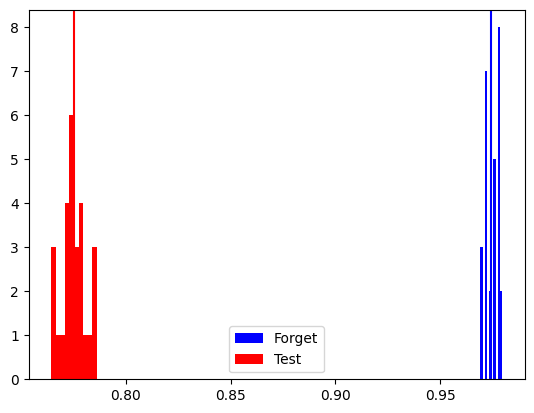

In [47]:
plt.hist(forget_accs, color='blue', label='Forget')
plt.axvline(x=np.mean(forget_accs), color='blue')
plt.hist(test_accs, color='red', label='Test')
plt.axvline(x=np.mean(test_accs), color='red')
plt.legend()
plt.show()

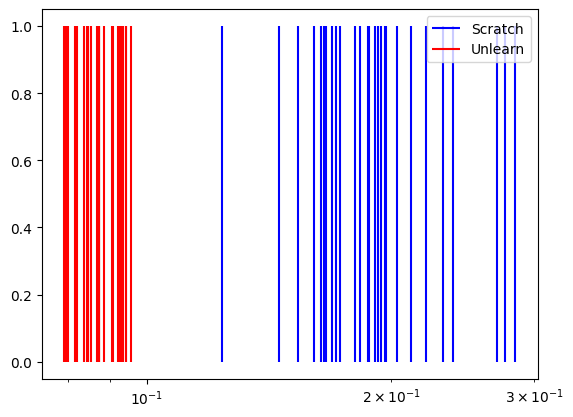

In [48]:
idx = 108
plt.vlines(original_losses[idx], ymin=0, ymax=1, color='blue', label='Scratch')
plt.vlines(unlearn_losses[idx], ymin=0, ymax=1, color='red', label='Unlearn')
plt.xscale('log')
plt.legend()
plt.show()

## Simple MIA

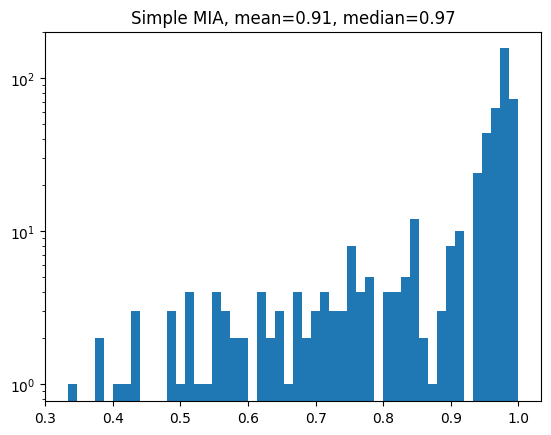

In [49]:
acc_scores = []

for idx, original_loss in enumerate(original_losses):
    acc_scores.append(simple_mia(original_loss, unlearn_losses[idx], n_splits=10, random_state=0).mean())

plt.hist(acc_scores, bins=50, log=True)
plt.title(f'Simple MIA, mean={np.mean(acc_scores):.2f}, median={np.median(acc_scores):.2f}');

## Paper forget score

In [50]:
f = forgetting_quality(
    unlearn_losses,
    original_losses,
    attacks=[tree_attack, best_threshold_attack], #best_threshold_attack logistic_regression_attack
    delta=0.01)
f

Computing F...: 100%|██████████| 27/27 [00:00<00:00, 123.49it/s]


0.0008138020833333334

In [51]:
RA_ratio = np.clip(np.mean(retain_accs) / RAR, 0, 1)
TA_ratio = np.clip(np.mean(test_accs) / TAR, 0, 1)
print(f'Final score: {f * RA_ratio * TA_ratio}')

Final score: 0.0007475903756660109


### KL

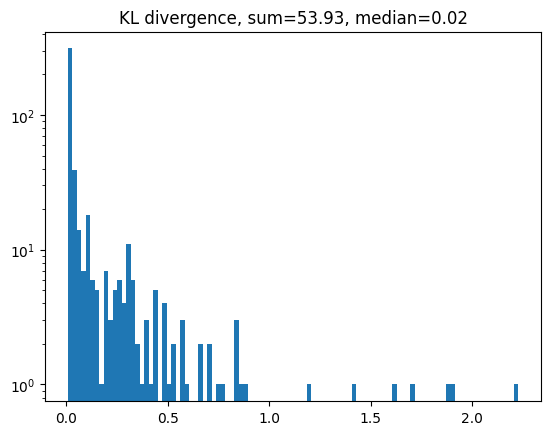

In [52]:
kl_losses = []
epsilon = 1e-2

for idx, original_loss in enumerate(original_losses):
    # losses_from_scratch = np.log(np.array(original_loss)/2 + epsilon)
    # losses_unlearn = np.log(np.array(unlearn_losses[idx]) + epsilon)

    # losses_from_scratch = np.random.lognormal(mean=losses_from_scratch.mean(), sigma=losses_from_scratch.std(), size=1000)
    # losses_unlearn = np.random.lognormal(mean=losses_unlearn.mean(), sigma=losses_unlearn.std(), size=1000)

    losses_from_scratch = np.array(original_loss)
    # losses_unlearn = np.array(unlearn_losses[idx])
    losses_unlearn = random.sample(unlearn_losses[idx], len(losses_from_scratch))

    # Ensure all losses are non-negative (they should naturally be if they are losses)
    # assert np.all(losses_from_scratch >= 0) and np.all(losses_unlearn >= 0), "Losses must be non-negative"

    # Normalize the losses to sum to one to represent probability distributions
    prob_dist_scratch = losses_from_scratch / np.sum(losses_from_scratch)
    prob_dist_unlearn = losses_unlearn / np.sum(losses_unlearn)

    prob_dist_scratch += epsilon
    prob_dist_unlearn += epsilon

    # Normalize again after adding epsilon to ensure they sum to one
    prob_dist_scratch /= np.sum(prob_dist_scratch)
    prob_dist_unlearn /= np.sum(prob_dist_unlearn)

    # Calculate the KL divergence from scratch to unlearn
    kl_divergence = kl_div(prob_dist_scratch, prob_dist_unlearn)

    # Sum over all elements to get the total divergence
    total_kl_divergence = np.sum(kl_divergence)

    kl_losses.append(total_kl_divergence)

plt.hist(kl_losses, bins=100, log=True)
plt.title(f'KL divergence, sum={np.sum(kl_losses):.2f}, median={np.median(kl_losses):.2f}')
plt.show()

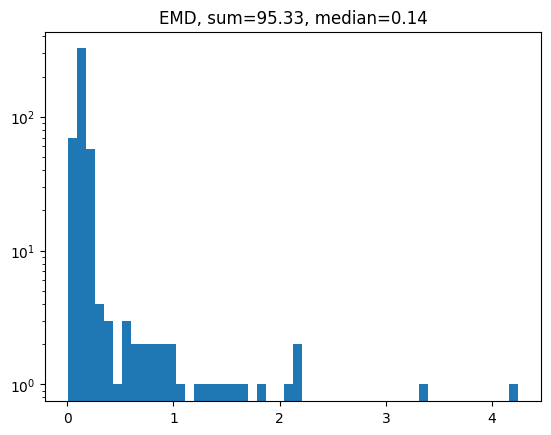

In [53]:
# Normalize losses, calculate standard deviation, and EMD per sample
emd_scores = []

for idx, original_loss in enumerate(original_losses):
   
    # Calculate Earth Mover's Distance
    emd_score = wasserstein_distance(original_loss, unlearn_losses[idx])
    emd_scores.append(emd_score)

plt.hist(emd_scores, bins=50, log=True)
plt.title(f'EMD, sum={np.sum(emd_scores):.2f}, median={np.median(emd_scores):.2f}');

In [54]:
# j = 0
# plt.hist(losses_from_scratch, color='blue', label='Trained from scratch')
# plt.axvline(x=np.mean(losses_from_scratch), color='blue')
# plt.hist(losses_unlearn, color='red', label='Unlearn')
# plt.axvline(x=np.mean(losses_unlearn), color='red')
# plt.yscale('log')
# plt.legend()
# plt.show()